<a href="https://colab.research.google.com/github/Andreylive/UAV-human-detection/blob/main/YOLOv5_(large%2C_pretrained).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!git pull

!git reset --hard 886f1c03d839575afecb059accf74296fad395b6

Cloning into 'yolov5'...
remote: Enumerating objects: 15641, done.
remote: Counting objects: 100% (248/248), done.
remote: Compressing objects: 100% (153/153), done.
remote: Total 15641 (delta 125), reused 169 (delta 95), pack-reused 15393
Receiving objects: 100% (15641/15641), 14.64 MiB | 4.42 MiB/s, done.
Resolving deltas: 100% (10653/10653), done.
/kaggle/working/yolov5
Already up to date.
HEAD is now at 886f1c0 DDP after autoanchor reorder (#2421)


In [ ]:
# install dependencies
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
from utils.google_utils import gdrive_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 2.0.0 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


In [ ]:
!curl -L "https://app.roboflow.com/ds/YCsKLvAbzh?key=wauxyPlLFl" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

curl: /opt/conda/lib/libcurl.so.4: no version information available (required by curl)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   901  100   901    0     0   2287      0 --:--:-- --:--:-- --:--:--  2292
100 67.7M  100 67.7M    0     0  85.0M      0 --:--:-- --:--:-- --:--:--  246M
Archive:  roboflow.zip
 extracting: README.roboflow.txt     
 extracting: data.yaml               
   creating: train/
   creating: train/images/
 extracting: train/images/train_BLA_0001_JPG.rf.6dfdc831a8d4eeccb161f8ec4135cb5c.jpg  
 extracting: train/images/train_BLA_0003_JPG.rf.c69e21b8092edf615d65223dce972852.jpg  
 extracting: train/images/train_BLA_0004_JPG.rf.50b023488b13e33cb0ad8a592ae8631d.jpg  
 extracting: train/images/train_BLA_0005_JPG.rf.eba3b36853391b05129bca52bf72e864.jpg  
 extracting: train/images/train_BLA_0007_JPG.rf.0593c71b90ae833c61c91eecf2a5cdca.jpg  
 extracting: tra

In [ ]:
# this is the YAML file Roboflow wrote for us that we're loading into this notebook with our data
%cat data.yaml

train: ../train/images
val: ../valid/images

nc: 1
names: ['human']

In [ ]:
# define number of classes based on YAML
import yaml
with open("data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [ ]:
#this is the model configuration we will use for our tutorial 
%cat ./data.yaml

train: ../train/images
val: ../valid/images

nc: 1
names: ['human']

In [ ]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [ ]:
%%writetemplate ./data.yaml

# parameters
train : ./train
val : ./valid
names : ['Person']
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [ ]:
%cat ./models/yolov5l.yaml

# parameters
nc: 80  # number of classes
depth_multiple: 1.0  # model depth multiple
width_multiple: 1.0  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, C3, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3,

In [ ]:
!pip install wandb -q

In [ ]:
!git pull

Updating 886f1c0..c3e4e94
Fast-forward
 .dockerignore                                      |   14 +-
 .github/ISSUE_TEMPLATE/bug-report.md               |   55 -
 .github/ISSUE_TEMPLATE/bug-report.yml              |   85 ++
 .github/ISSUE_TEMPLATE/config.yml                  |   11 +
 .github/ISSUE_TEMPLATE/feature-request.md          |   27 -
 .github/ISSUE_TEMPLATE/feature-request.yml         |   50 +
 .github/ISSUE_TEMPLATE/question.md                 |   13 -
 .github/ISSUE_TEMPLATE/question.yml                |   33 +
 .github/PULL_REQUEST_TEMPLATE.md                   |   13 +
 .github/dependabot.yml                             |   31 +-
 .github/workflows/ci-testing.yml                   |  197 ++-
 .github/workflows/codeql-analysis.yml              |   67 +-
 .github/workflows/docker.yml                       |   58 +
 .github/workflows/greetings.yml                    |   73 +-
 .github/workflows/links.yml                        |   44 +
 .github/workflows/rebase.yml          

In [ ]:
if torch.cuda.is_available():
    print("GPU is available")
    device = torch.device("cuda:0")
else:
    print("GPU not available, using CPU instead")
    device = torch.device("cpu")

GPU is available


In [ ]:
!export WANDB_API_KEY=742aac2df6aee3508d1fdb5ad95cb60e7ea2dbdd && python train.py --img 416 --batch 16 --epochs 100 --data './data.yaml' --cfg ./models/yolov5l.yaml --weights yolov5l.pt --name ./yolov5l_results --cache

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: Currently logged in as: maxim652002 (itmo_). Use `wandb login --relogin` to force relogin
train: weights=yolov5l.pt, cfg=./models/yolov5l.yaml, data=./data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=./yolov5l_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
requirements: /kaggle/working/requirements.txt not found

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

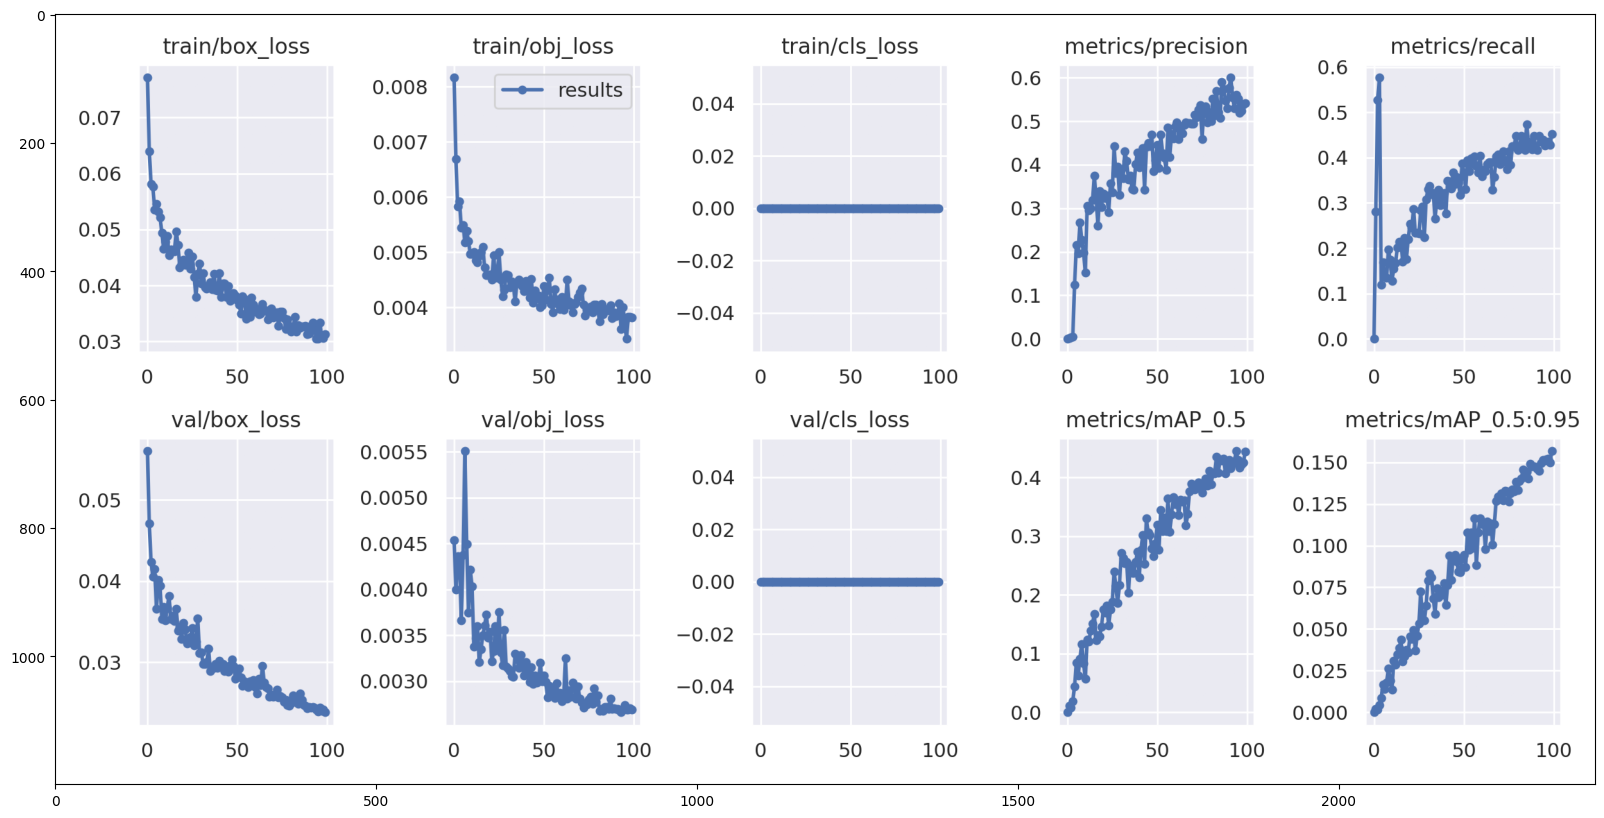

In [ ]:
img = mpimg.imread('./runs/train/yolov5l_results/results.png')

plt.figure(figsize=(20, 10))
plt.imshow(img)
plt.show()

In [ ]:
!python detect.py --weights ./runs/train/yolov5l_results/weights/best.pt --img 416 --conf 0.4 --source ./valid/images

detect: weights=['./runs/train/yolov5l_results/weights/best.pt'], source=./valid/images, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
requirements: /kaggle/working/requirements.txt not found, check failed.
YOLOv5 🚀 v7.0-162-gc3e4e94 Python-3.10.10 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5l summary: 267 layers, 46108278 parameters, 0 gradients, 107.6 GFLOPs
image 1/377 /kaggle/working/yolov5/valid/images/train_BLA_0002_JPG.rf.0853fda95c799c8d505bdcf8bb5937d4.jpg: 416x416 4 Persons, 31.6ms
image 2/377 /kaggle/working/yolov5/valid/images/train_BLA_0006_JPG.rf.586dd34289f6bc89c3fd33b16c30190e.jpg: 416x416 3 Persons, 31.6ms


In [ ]:
!python val.py --weights ./runs/train/yolov5l_results/weights/best.pt --data ./data.yaml --img 416 --half

val: data=./data.yaml, weights=['./runs/train/yolov5l_results/weights/best.pt'], batch_size=32, imgsz=416, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=True, dnn=False
requirements: /kaggle/working/requirements.txt not found, check failed.
YOLOv5 🚀 v7.0-162-gc3e4e94 Python-3.10.10 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5l summary: 267 layers, 46108278 parameters, 0 gradients, 107.6 GFLOPs
val: Scanning /kaggle/working/yolov5/valid/labels.cache... 377 images, 149 backg
                 Class     Images  Instances          P          R      mAP50   
                   all        377        638      0.542       0.45      0.443      0.157
Speed: 0.2ms pre-process, 5.4ms inference, 1.7ms NMS per image at shape (32, 3, 416, 416)
Results saved to runs/val/exp


In [ ]:
!ls /runs/val/exp

ls: cannot access '/runs/val/exp': No such file or directory


#### FPS

 - Pre-process time: 0.2ms
 - Inference time: 5.4ms
 - NMS (Non-Maximum Suppression) time: 1.7ms
    
 - Общее время на изображение (в секундах) = (0,3 + 15,2 + 0,5) / 1000 = 0,016 секунд
 - FPS = 1 / Общее время на изображение = 1 / 0,0073 = 62,5